# 5. Model selection

[*This is part 5 of a 6-part tutorial on machine learning in scikit-learn.*]

Machine learners often emphasize the importance of having very large training datasets. It's all well and good to say that if we want to make good predictions, we should collect an enormous amount of data; the trouble is that sometimes that's not feasible. For example, if we're neuroimaging researchers acquiring structural brain scans from people with an autism diagnosis, it's not as if we can just magically make tens of thousands of scans appear out of thin air. We may only be able to pool together one or two thousands data points, even with a monumental multi-site effort like the ABIDE initiative.

If we can't get a lot more data, are there other steps we can take to improve our predictions? We've already seen how cross-validation methods can indirectly help us make better predictions by minimizing overfitting and obtaining saner estimates of our models' true generalization abilities. In this section, we'll explore steps we can take to directly improve predictions by selecting better models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# plotting utilities we'll use but won't discuss in the notebook
from support import plot_learning_curves, bias_variance_dartboard

In [2]:
# Read in the ABIDE-II dataset
data = pd.read_csv('/home/jovyan/shared/abide2/abide2.tsv', sep='\t')

# Extract all the Freesurfer features into their own DF
features = data.filter(like='fs')

# We'll use age as the labels everywhere
y = data['age']

## Bias and variance
We've talked about the tradeoff between overfitting and underfitting, and the related tradeoff between flexibility and stability in estimation. Now we'll introduce a third intimately-related pair of concepts: bias and variance. Understanding the difference between bias and variance, and why we can often trade one for the other, is central to developing good intuitions about when and how to select good estimators.

It's probably easiest to understand the concepts of bias and variance through visual illustration. Here's a classic representation:

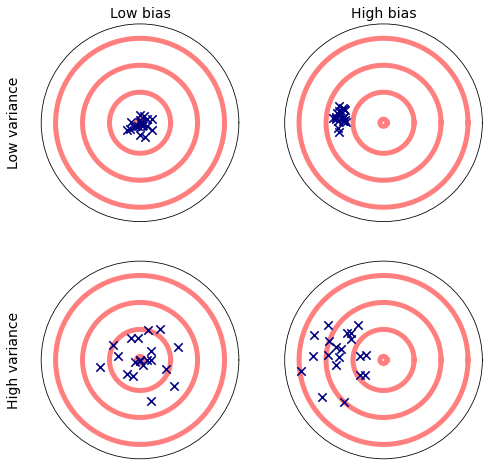

In [3]:
bias_variance_dartboard()

Comparing the top and bottom rows gives us a sense of what we mean by *variance*: it's the degree of scatter of our observations around their central tendency. In the context of statistical estimators, we say that an estimator has high variance if the parameter values it produces tend to vary widely over the space of datasets it could be applied to. Conversely, a low-variance estimator tends to produce similar parameter estimates when applied to different datasets.

Bias, by contrast, refers to a statistical estimator's tendency to produce parameter estimates that cluster in a specific part of the parameter space. A high-bias estimator produces parameter estimates that are systematically shifted away from the center of the space towards some other region. A low-bias estimator has no particular preference for one region of space—it tends to produce estimates that distribute relatively evenly through parameter space.

### The bias-variance tradeoff
One interesting property of bias and variance is that they tend to trade off. That is, one can often decrease the variance of an estimator by deliberately increasing its bias, or vice versa. To see this intuitively, imagine the extreme case of an estimator that always generates an identical prediction for all observations. Such an estimator would have low variance (actually, *no* variance) and extremely high bias. Conversely, an estimator that produces extremely variable estimates must be one capable of freely exploring various parts of parameter space—and hence, shows a weaker preference for, or bias towards, certain parts of the space.

This idea has a deep connection to the overfitting/underfitting and flexibility/stability distinctions we drew earlier. In fact, all three distinctions ultimately reflect the same core idea. A *high-variance* (low-bias) estimator is a *flexible* one that can identify a wide variety of patterns in the data; this also makes it more likely to *overfit*. Conversely, a high-bias (low-variance) estimator is a *stable* one that tends to produce similar parameter estimates no matter what data it's presented with; such an estimator will frequently *underfit*, because it lacks the flexibility needed to capture complex patterns in the data.

Scientists often think of bias as a dirty word—i.e., as something to be minimized at all costs. From a machine learning standpoint, however, there's nothing intrinsically bad about bias. The bias of a particular model is nothing more than its systematic tendency to produce parameter estimates that cluster within a particular part of the space (underscoring this point, machine learning researchers usually refer to the intercept of a statistical model as its bias term). Not only is this not a bad thing, it's often absolutely essential for producing good predictions. The key question is this: *to what degree does the inductive bias of a given estimator match the processes that give rise to our data?*

In cases where there's a match between an estimator and the data it's applied to, a biased estimator will tend to perform better than a less biased one. Conversely, if an estimator has the *wrong* bias, it will tend to perform more poorly than an estimator with less bias.

This is a fairly abstract idea, so let's make it concrete. Suppose you park your car at the airport parking lot when you head off for a weekend vacation. Consider two possible strategies you could use to find your car on your return. First, you might rely on your memory of where you left the car; perhaps you think you left it somewhere near that light pole over there in the `B` area of the lot. Second, you could just randomly roam around the parking lot looking for a car the same make and color as yours.

Which of these is the better car-finding strategy? Hopefully you can intuitively see why the answer is "it depends". If you have a good memory, the high-bias strategy—of only looking in a particular part of the lot—will lead you to your car more quickly than a random walk around the entire lot. But if your memory is poor, the biased strategy is likely to be counterproductive, because your car won't be where you remember leaving it, no matter how much time you spend walking around that area. In the latter case, you would have been better off randomly walking around until you found your car.

![](images/parkinglot.jpg)

## Regularization
Our car parking example is a bit contrived, but it illustrates a core principle at the heart of good model selection: *if we have useful prior knowledge about the domain, we should pick an estimator that builds that knowledge into its assumptions*. For example, if we have a set of 1,000 potential features we could use in our model, but have good reason to believe that only a small fraction of those features make a meaningful contribution to the outcome variable, it seems like a good idea to pick an estimator that can somehow *select* a subset of features. Using an estimator that acts as if all of our features are potentially important (as linear regression does) is likely to lead to overfitting.

The principle of introducing background knowledge into our model in order to improve predictions and prevent overfitting is known in machine learning and statistics as *regularization*. When we say we're using a regularized estimator, what we're typically saying is that we've taken an existing estimator (e.g., an OLS estimator) and constrained it with additional information some way, so that it's *biased* towards certain parts of the parameter space.

<small>(A quick side note: Readers familiar with Bayesian analysis may at this point be thinking, *hey, this sounds a lot like the rationale for using priors in Bayesian statistical analysis*. This isn't a coincidence! Conceptually, regularization achieves the same objective as Bayesian priors, and many forms of regularization can be formalized equivalently in terms of prior distributions over model parameters.)</small>

### Penalized regression
If you're coming from a biomedical or social science background, it may be tempting to think of least-squares estimation as a kind of automatic default, with all other procedures requiring some special justification to use. But there's nothing terribly special about OLS. Well, it's special in that it always minimizes the squared error in our training sample. But as we've already seen, we usually care about minimizing test error, not training error (plus, sometimes we don't want to quantify error in terms of a least-squares criterion). So if we can get our hands on an estimator that's biased with respect to OLS, but tends to reduce error in the *test* dataset, we probably still want to use it—even if it doesn't reduce error in the *training* data quite as well as OLS.

Fortunately for us, there are many, many such estimators. One of the most widely used class of estimators for regression problems is *penalized regression*. These methods generally begin with garden variety OLS, and then add a little twist in the form of a *penalty* parameter.

Consider the cost function we seek to minimize in OLS:

$Cost = RSS = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2$

Here, $RSS$ is the residual sum of squares, $N$ is the number of samples, and $P$ is the number of features. Our goal is to obtain the set of $\beta$ coefficients that minimize the $RSS$.

Now consider a slight variation:

$Cost = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2 + \lambda\sum^P_j|\beta_j|$

The only difference here is that, in addition to the $RSS$, our cost function includes a second term, $ \lambda\sum^P_j|\beta_j|$—the sum of absolute values of the $\beta$ coefficients, weighted by the *penalty* parameter $\lambda$.The addition of the penalty parameter is the reason we refer to this variation on linear regression as penalized regression. The addition of the penalty may seem like a small change, but it has major consequences, which we'll explore shortly.

The above form of penalized regression is known as [*lasso regression*](https://en.wikipedia.org/wiki/Lasso_(statistics)), and it's very widely used. There's also another very common form of penalized regression known as [*ridge regression*](https://en.wikipedia.org/wiki/Tikhonov_regularization). It looks a lot like lasso regression, except instead of computing the penalty as the sum of absolute coefficients, we take their squared sum:

$Cost = \sum^N_i(y_i - \sum^P_j\beta_jx_{ij})^2 + \lambda\sum^P_j\beta_j^2$

The difference between lasso and ridge regression may seem even smaller, but it again has important implications. Let's explore the behavior of each of these methods.

#### Lasso regression
Let's take the lasso first. Let's think about what the addition of the penalty term to the standard RSS criterion does, conceptually. By making the overall cost depend on a (weighted) sum of absolute coefficients, we're basically saying that there's a certain cost to having large coefficients in our model. If the net negative contribution of a given feature to the RSS is smaller than its net positive contribution to the penalty, then it will be beneficial to "shrink" that feature's coefficient to the point where the two terms perfectly cancel each other out. Thus, penalized regression *biases* the estimated regression coefficients by shrinking at least some of them.

For reasons outside the scope of this tutorial (see Figure 1 of [this paper](https://www.stat.cmu.edu/~larry/=sml/sparsity.pdf)), the lasso doesn't just shrink coefficients; it actually shrinks them all the way to zero. That is, as we increase the penalty, more features drop out of our model, leaving us with a simpler prediction equation involving fewer features. For this reason, the lasso is often described as implicitly included a *feature selection* step (we'll come back to this idea of feature selection in Section 6).

To see how this works in practice, let's return to our ABIDE-II data and visualize what happens to our regression coefficients estimated with lasso regression as we increase the penalty parameter. We'll write a little helper to plot *coefficient paths*...

In [4]:
def plot_coef_path(estimator, X, y, alpha, ax=None, **kwargs):
    if ax is None:
        ax = plt.figure().gca()
    coefs = np.zeros((X.shape[1], len(alpha)))
    for (i, a) in enumerate(alpha):
        coefs[:,i] = estimator(alpha=a, **kwargs).fit(X, y).coef_
    ax.plot(alpha, coefs.T)
    ax.set_xlabel("Penalty (alpha)")
    ax.set_ylabel("Coefficient value")
    ax.set_xscale('log')

...and now we'll apply it to our data, judiciously picking a reasonable range of $\lambda$ values.

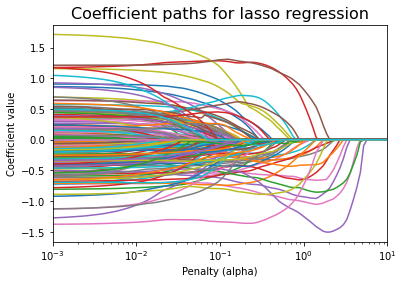

In [5]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

# Feel free to change this and re-run the rest of the cells in the
# notebook. It may have a big effect on the coefficient path plots!
NUMBER_OF_FEATURES = 200

X = features.sample(NUMBER_OF_FEATURES, axis=1, random_state=99)

# You can replace 'age' with 'age_resid' if you like
y = data['age']

# Note: we standardize our features to mean-zero and unit-variance,
# because lasso and ridge are sensitive to scale.
X = scale(X)

# Coefficient paths for ridge regression, predicting age from 30 features
alpha = np.logspace(-3, 1, 100)
plot_coef_path(Lasso, X, y, alpha, max_iter=2000)

plt.title("Coefficient paths for lasso regression", fontsize=16)
plt.xlim(1e-3, 10);

Here, each colored line represents a different feature. We're using 200 randomly selected features (from the full set of 1,440) as predictors, so there are 200 lines. The x-axis displays the penalty parameter used for lasso estimation; the y-axis displays the resulting value of the coefficients. Notice how, at a certain point (around `alpha = 0.01`), coefficients start to disappear. They're not just small; they're *gone* (i.e., they've been "shrunk" all the way to 0). This built-in feature selection is a very useful property of the lasso. It allows us to achieve an arbitrarily sparse solution simply by increasing the penalty.

Of course, as you know by now, *there's no free lunch in machine learning*. There must be some price we pay for the interpretability of the lasso solution, right? There is. We'll look at it in a moment; but first, let's talk about ridge regression.

#### Ridge regression
Ridge regression, as noted above, is mathematically very similar to lasso regression. But it behaves very differently. Whereas the lasso produces sparse solutions, ridge regression, like OLS, always produces dense ones. Ridge *does* still shrink the coefficients (i.e., their absolute values get smaller as the penalty increases). It also pushes them towards a normal distribution (in fact—for readers with a Bayesian statistics background—ridge regression is equivalent to imposing a normal hyperprior over all coefficients). The latter property is the reason a well-tuned ridge regression model usually outperforms OLS: you can think of ridge regularization as basically a way of saying *hey, it may **look** like a few of the OLS coefficients are way bigger than others, that's probably a sign we're fitting noise. So let's squash all of the extreme values towards zero a bit, so that all of our coefficients are relatively small and bunched together.*

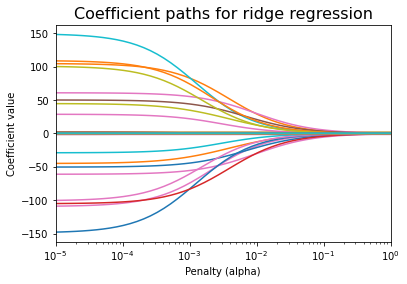

In [6]:
from sklearn.linear_model import Ridge

# Coefficient paths for ridge regression, predicting age from 30 features
alpha = np.logspace(-5, 5, 100)
plot_coef_path(Ridge, X, y, alpha)

plt.title("Coefficient paths for ridge regression", fontsize=16)
plt.xlim(1e-5, 1);

It may *look* like the coefficients are shrinking all the way to zero here, but they aren't. They're just getting really, really small.

#### Effects of regularization on predictive performance
We've looked at two different flavors of penalized regression, and established that they behave quite differently. So, which one should we use? Which is the *better* regularization approach? Well, as with everything else—and stop me if you've heard this one before—*it depends*. If the process(es) that generated our data are sparse (or at least, have a good sparse approximation)—meaning, a few of our features make very large contributions, and the result don't much matter—then lasso regression will tend to perform better. If the data-generating process is dense—i.e., lots of factors make small contributions to the outcomes—then ridge regression will tend to perform better.

In practice, we almost never know the ground truth when working with empirical data. So we're forced to rely on a mix of experience, intuition, and validation analyses.

Let's do some of the latter here. To try to figure out what the optimal lasso and ridge penalties are for our particular problem, we'll make use of scikit-learn's `validation_curve` utility, which allows us to quickly generate training and testing performance estimates for an estimator as a function of one of its parameters. As alluded to in Section 4, the `validation_curve` is very similar to the `learning_curve` we've seen repeatedly, except that instead of systematically varying the dataset size, we systematically vary one of the estimator's parameters (in this case, `alpha`).

First, let's write a plotting function we can reuse.

In [7]:
def plot_train_test(x_range, train_scores, test_scores, label, hlines=None):
    plt.plot(x_range, train_scores.mean(1), label=f'{label} (train)', linewidth=2)
    plt.plot(x_range, test_scores.mean(1), label=f'{label} (test)', linewidth=2)
    plt.grid(axis='y', linestyle='--')
    plt.xscale('log')
    plt.ylabel('$R^2$', fontsize=14)
    plt.xlabel('Penalty (alpha)', fontsize=14)
    plt.ylim(0, 1)

    if hlines:
        for lab, line in hlines.items():
            plt.hlines(line, x_range.min(), x_range.max(), linestyles='--', linewidth=2, label=lab)

    plt.legend(fontsize=14)

Now let's generate a validation curve for lasso regression, still using 200 random features to predict age.

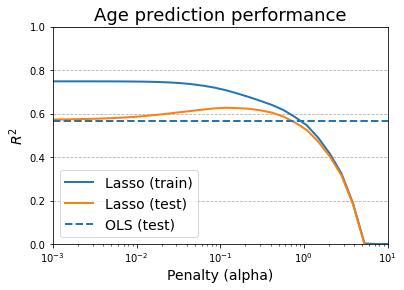

In [8]:
from sklearn.model_selection import validation_curve

x_range = np.logspace(-3, 1, 30)
train_scores, test_scores = validation_curve(Lasso(max_iter=5000), X, y, 
                                             param_name='alpha', 
                                             param_range=x_range, 
                                             cv=5,
                                             scoring='r2')

# Add OLS R^2 for reference
ols_r2 = cross_val_score(LinearRegression(), X, y, scoring='r2', cv=5).mean()

plot_train_test(x_range, train_scores, test_scores, 'Lasso', hlines={'OLS (test)': ols_r2})
plt.title("Age prediction performance", fontsize=18)
plt.xlim(1e-3, 10);

Notice that, in the training dataset, $R^2$ decreases monotonically as alpha increases. This is necessarily true. Why? (*Hint*: think of how $R^2$ is defined, and its relationship to the least-squares component of the lasso cost function.)

In contrast, the error in the test dataset is lowest within a specific range of `alpha` values. This optimum will vary across datasets, so you'll almost always need to tune the alpha parameter (e.g., using a validation curve like the one above) to get the best performance out of your model. This extra degree of complexity in the estimation process is one of the reasons you might *not* want to opt for a penalized version of OLS, even if you think it'll probably improve your predictions somewhat. If you muck things up and pick the wrong penalty, your predictions could be way worse than OLS!

Let's do the same thing, but this time for ridge regression.

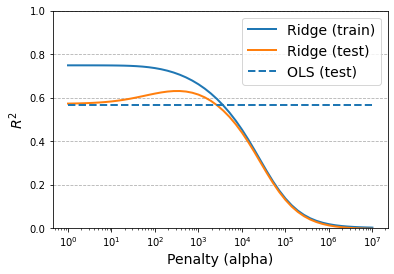

In [9]:
x_range = np.logspace(0, 7, 50)
train_scores, test_scores = validation_curve(Ridge(), X, y, 
                                             param_name='alpha', 
                                             param_range=x_range, 
                                             cv=5,
                                             scoring='r2')
plot_train_test(x_range, train_scores, test_scores, 'Ridge', hlines={'OLS (test)': ols_r2})

Like lasso regression, ridge regression outperform OLS in the test data—but only within a certain range of penalty values, once again illustrating the bias variance tradeoff (i.e., introducing the *right* bias will help us, but if we're wrong, we would have been better off with a less biased, higher-variance approach).

While we've only looked at one dataset, these are fairly typical results; in many application domains, penalized regression models tend to outperform OLS when using small to moderate-sized samples. When samples get very large relative to the number of features, the performance difference usually disappears. Outside of domains with extremely structured and high-dimensional data, this latter principle tends to be true more globally—i.e., "more data usually beats better algorithms."

## Beyond regression

We've focused our attention here on lasso and ridge regression because they're regularized versions of the OLS estimator most social scientists are already familiar with. But just as there's nothing special about OLS, there's also nothing special about (penalized) regression in general. There are many different estimators we could use to generate predictions. Each has its own inductive biases, and will perform better on some datasets and worse on others. The science (or perhaps art) of machine learning lies in understanding the available estimators, data, and validation methods well enough to know how to tailor optimal (or at least good) machine learning workflows to the specific problem at hand.

Here's a very popular flowchart by sklearn core contributor [Andreas Mueller](https://datascience.columbia.edu/andreas-mueller) that can help identify good candidate estimators for one's problem.

![sklearn flowchart](https://scikit-learn.org/stable/_static/ml_map.png)

It goes without saying that the flowchart should be taken as heuristic advice, not as a deterministic procedure for selecting the best estimator.

### Random forests
To illustrate how easy it is to try out completely different types of estimators in scikit-learn--and also draw attention to the fact that estimators based on linear regression represent only a small part of the space--let's repeat some of our earlier regression analyses using a very different estimator: the `RandomForestRegressor`. Random forests are essentially collections (or *ensembles*) of decision trees. A decision tree is a structure for generating classification (classification trees) or regression (regression trees) predictions. Here's an example of what a regression tree might look like, if used in our ABIDE-II dataset to try and predict age from structural brain features:

![decision tree example](images/tree.png)

At each node, we evaluate a particular conditional. For example, the first question we ask is: is the subject's observed value on the fsCT_218 variable less than or equal to 2.49, or is it greater? We follow the appropriate branch to the next node, and answer the question we find there. We repeat this process until we reach a terminal node (or "leaf"), whereupon the tree produces the predicted value for that observation.

Random forests extend this idea by "bagging" multiple decision trees and aggregating their outputs. Decision trees are very flexible, and have a propensity to overfit. By averaging over a lot of different trees (each one generated by, e.g., resampling the data), we hopefully stabilize our predictions and reduce overfitting. Random forests are popular because they're extremely powerful, their constituent trees are highly interpretable, and they tend to perform well when we have a lot of data. The downsides are that, being very flexible, they have a tendency to overfit, and careful tuning may be required to achieve good performance. They can also be quite slow, as performance tends to improve with the number of decision trees.
<div style="margin-top: 20px;">


</div>

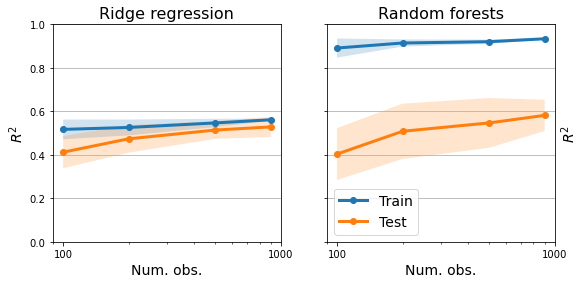

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

NUMBER_OF_FEATURES = 50
ALPHA = 100
NUMBER_OF_TREES_IN_FOREST = 10

# Select N "best" features to reduce tree complexity and overfitting
selector = SelectKBest(f_regression, k=NUMBER_OF_FEATURES)
X = selector.fit_transform(features, y)

# ideally we'd want to use a larger number of trees,
# but this would be very slow, so we stick with
# a small number for demonstration purposes.
estimators = [Ridge(ALPHA), RandomForestRegressor(NUMBER_OF_TREES_IN_FOREST)]
labels = ["Ridge regression", "Random forests"]

plot_learning_curves(estimators, [X, X], y, [100, 200, 500, 900], labels)

In this case, the random forest estimator outperforms ridge regression, particularly as the sample size gets larger. But it's worth reiterating our earlier point: this isn't some kind of law, or even a particularly good heuristic; if you play with various parameters above (e.g., `NUMBER_OF_FEATURES`, `ALPHA`, etc.), you can easily find regimes under which ridge regression performs better.

#### Interpreting random forests
Unlike regression-based methods, decision trees (and hence random forests) don't have linear coefficients. Instead, we can obtain *feature importances*, which tell us how important each feature is to the overall prediction (more important features are better at reducing uncertainty, and occur closer to the root of the tree).

In [11]:
rf = RandomForestRegressor(100)

# sample 30 random features
X = features.sample(30, axis=1)
rf.fit(X, y)

pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

fsVol_L_POS2_ROI     0.193505
fsCT_L_d23ab_ROI     0.192948
fsVol_L_3a_ROI       0.047488
fsVol_R_9p_ROI       0.038104
fsVol_R_STSva_ROI    0.037305
fsArea_L_7m_ROI      0.035501
fsCT_R_9p_ROI        0.031157
fsVol_R_POS2_ROI     0.030214
fsCT_L_PI_ROI        0.029880
fsArea_R_11l_ROI     0.028634
dtype: float64

Be aware that there are a number of important subtleties related to the interpretation of feature importances, not least of which is that, as with any model, feature importances are configural: a feature may seem important when modeled alongside one set of other features, but unimportant when included with a different set of features.

#### Visualizing trees
We can also plot the individual decision trees. Note that different trees can often exhibit very different structures despite performing equally well predictively—an observation that should lead us to exercise caution when interpreting decision trees, even if they *seem* straightforward. In this particular case, as we saw above, a handful of features dominate the list of feature importances, so we might expect at least the first few nodes to look relatively similar. Let's take a look at the first two trees in the forest.

In [12]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image, display

def plot_graphviz_tree(tree):
    """
    Helper function that takes a tree as input, calls sklearn's export_graphviz
    function to generate an image of the tree using graphviz, and then
    plots the result in-line.
    """
    export_graphviz(tree, out_file='tree.dot', max_depth=3, filled=True,
                    feature_names=X.columns, impurity=False, rounded=True,
                    proportion=False, precision=2);

    call(['dot', '-Tpng', 'tree.dot', '-o', 'images/tree.png', '-Gdpi=600'])
    display(Image(filename = 'images/tree.png'));

In [13]:
# First tree in the forest
plot_graphviz_tree(rf.estimators_[0]);

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

In [ ]:
# Second tree in the forest
plot_graphviz_tree(rf.estimators_[1]);